## Running population-based simulations in *gpvolve* using SLiM

Current functionality of `gpvolve.slimsim.GenotypePhenotypeSLiM`

In [1]:
import gpmap, gpvolve, os, shutil
from IPython.display import Image

import os
#os.chdir("SLiM")
os.getcwd()

'/Users/harmsm/work/programming/git-clones/gpvolve/examples/SLiM'

### 1. Generate a rough mount fuji map with 5 sites, each with 2 states

`GenotypePhenotypeSLiM` is built around a `GenotypePhenotypeMap` object that informs the fitness values of each genotype

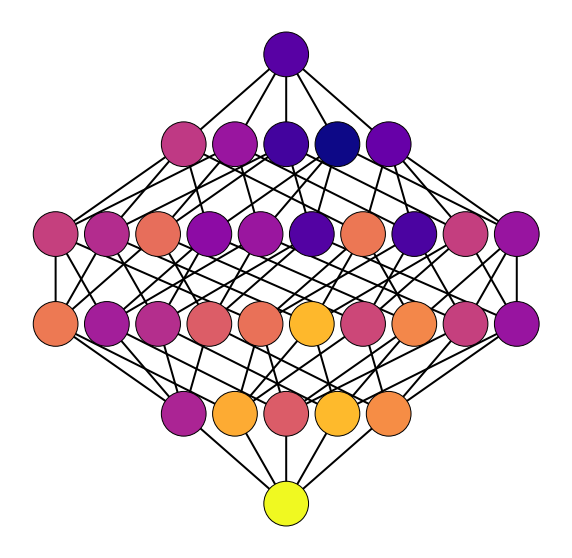

In [2]:
# make map
gpm = gpmap.simulate.generate_gpm(alphabet='01', num_sites=5, num_states_per_site=2)

# generate fuji fitness landscape towards derived state
gpm.data.loc[:, 'fitness'] = gpmap.simulate.fuji(gpm, ref_genotype = '11111', roughness = 0.1)
gpm.data.loc[len(gpm.data)-1,'fitness']=max(gpm.data.fitness)+0.1
gpm.data.loc[gpm.data.fitness < 0, 'fitness'] = 0
gpm.get_neighbors()

# plot
G=gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
mask = gpm.neighbors.direction != 1
gpm.neighbors.loc[mask,"include"] = False
G.add_node_cmap(data_column="fitness")
G.edge_options["arrows"] = None
G.edge_options["arrowsize"]=0.001
G.node_options["node_size"] = 2000
g = gpmap.plot(G, plot_node_labels=False, edge_options={'width':2})

#### 1.5. Create a directory for SLiM files

SLiM relies on a different language to read/write files, so a separate directory for its inputs and outputs can help keep things tidy

In [3]:
# delete test run if it already exists
if os.path.exists('SLiM_demo'):
    shutil.rmtree('SLiM_demo')
os.makedirs('SLiM_demo')

### 2. Initialize `GenotypePhenotypeSLiM` object, run a simulation

The primary function of the `GenotypePhenotypeSLiM` object is to run a SLiM simulation, which returns the object with SLiM results as attributes.

`slimulate()` takes the following parameters:

- `population_size`

    number of individuals in the population
- `mutation_rate`

    mutation rate (per site per generation)
- `max_generation`

    number of generations to run simulation for (simulation will finish if all mutations fix before)
- `outpath`
    
    path for SLiM write/read files
- `overwrite (default = False)` 

    if `GenotypePhenotypeSLiM` files exist at the outpath, overwrite them (otherwise throw error)
- `slim_path (default = 'slim')`

    path to SLiM build (if installed via PyPI, just 'slim')
- `haploid (default = False)`

    run a haploid population?
- `slim_column (default = 'fitness')`

    column for SLiM to consider as the fitness value

In [4]:
# load gpmap into slimsim
#sim = gpvolve.simulate.GenotypePhenotypeSLiM(gpm)

# run "simulation
sim = gpvolve.simulate.slim.simulate(gpm,
                population_size = 1000,
              mutation_rate = .01,
              max_generations = 500,
              outpath = 'SLiM_demo/5_site_fuji',
              overwrite=True,
              slim_path = 'slim',
              fitness_column = 'fitness')

slim -d MUTATIONRATE=0.01 -d POPULATIONSIZE=1000 -d GPMAP=\"SLiM_demo/5_site_fuji_gpmap_SLiM.txt\" -d OUTPATH=\"SLiM_demo/5_site_fuji\" SLiM_demo/5_site_fuji.slim


### 3. Looking at outputs

Running `.slimulate()` establishes attributes of the `GenotypePhenotypeSLiM` object that store outputs from the SLiM simulation

#### `.node_counts`

Pandas DataFrame containing the number of individuals occupying each node (columns) at each generation (rows). Visualized using `.plot_gt()` (rough function right now)

In [5]:
# dataframe

len(sim.node_counts)

226

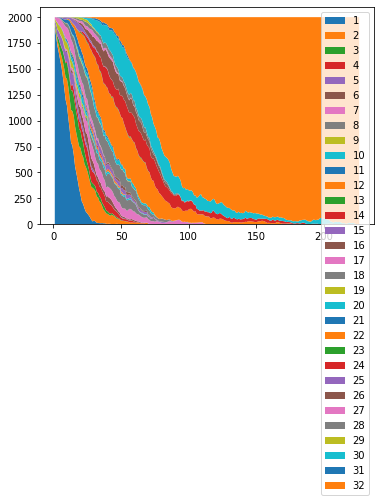

In [6]:
# plot number of occupants at each node over time

plot = sim.plot_gt()

#### `.edge_weights`

Dictionary containing the scaled weights of each edge step. Visualized using `.plot_flux()`

In [7]:
# print dictionary

sim.edge_weights

{(0, 16): 0.3035,
 (0, 8): 0.0295,
 (0, 4): 0.0755,
 (0, 2): 0.2555,
 (0, 1): 0.336,
 (16, 20): 0.1065,
 (16, 17): 0.197,
 (8, 24): 0.0205,
 (8, 9): 0.009,
 (4, 6): 0.0305,
 (4, 5): 0.045,
 (2, 10): 0.082,
 (2, 6): 0.1735,
 (1, 17): 0.2255,
 (1, 9): 0.032,
 (1, 5): 0.0785,
 (20, 21): 0.1065,
 (17, 21): 0.2535,
 (17, 19): 0.169,
 (24, 26): 0.0205,
 (9, 25): 0.041,
 (6, 7): 0.16,
 (5, 21): 0.1235,
 (10, 26): 0.082,
 (6, 22): 0.044,
 (21, 29): 0.414,
 (21, 23): 0.0695,
 (19, 27): 0.0835,
 (19, 23): 0.0855,
 (26, 27): 0.0205,
 (25, 29): 0.041,
 (7, 15): 0.0305,
 (26, 30): 0.082,
 (22, 23): 0.044,
 (7, 23): 0.1295,
 (29, 31): 0.455,
 (23, 31): 0.3285,
 (27, 31): 0.104,
 (15, 31): 0.0305,
 (30, 31): 0.082}

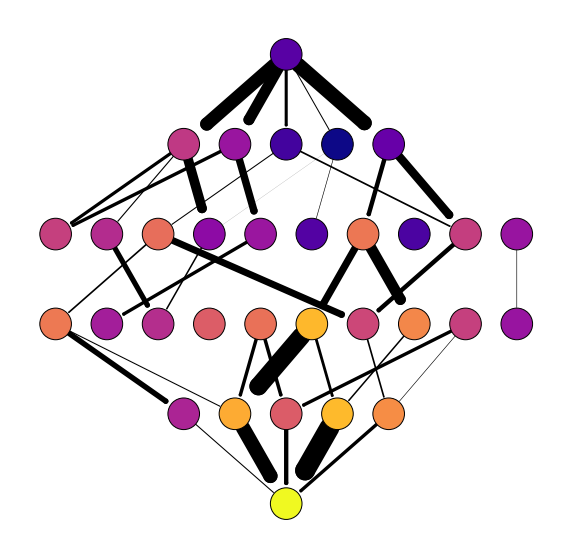

In [8]:
# plot edge flux

g = sim.plot_flux()

#### `.edge_counts`

Pandas DataFrame containing the number of each edge step observed (columns) at each generation (rows).  Visualized using `.animate_flux(outpath)`

In [9]:
# print dictionary

sim.edge_counts

(0, 1)  (0, 2)  (0, 4)  (0, 5)  (0, 6)  (0, 8)  (0, 9)  (0, 10)  (0, 12)  \
0         0       0       0       0       0       0       0        0        0   
1        19      19      22       0       0      17       0        0        0   
2        18      19      18       0       0      16       2        0        0   
3        15      18      19       0       0      29       0        0        2   
4        12      13      14       0       0      19       2        0        0   
..      ...     ...     ...     ...     ...     ...     ...      ...      ...   
222       0       0       0       0       0       0       0        0        0   
223       0       0       0       0       0       0       0        0        0   
224       0       0       0       0       0       0       0        0        0   
225       0       0       0       0       0       0       0        0        0   
226       0       0       0       0       0       0       0        0        0   

     (0, 16)  ...  (25, 27)  (25, 29)  (26, 27)  (26, 30)  (26, 31)  (27, 31)  \
0          0  ...         0         0         0         0         0         0   
1         16  ...         0         0         0         0         0         0   
2         17  ...         0         0         0         0         0         0   
3         14  ...         0         0         0         0         0         0   
4         17  ...         0         0         0         0         0         0   
..       ...  ...       ...       ...       ...       ...       ...       ...   
222        0  ...         0         0         0         0         0         0   
223        0  ...         0         0         0         0         0         0   
224        0  ...         0         0         0         0         0         0   
225        0  ...         0         0         0         0         0         0   
226        0  ...         0         0         0         0         0         0   

     (28, 29)  (28, 30)  (29, 31)  (30, 31)  
0           0         0         0         0  
1           0         0         0         0  
2           0         0         0         0  
3           0         0         0         0  
4           0         0         0         0  
..        ...       ...       ...       ...  
222         0         0         0         0  
223         0         0         0         0  
224         0         0         0         0  
225         0         0         0         0  
226         0         0         0         0  

[227 rows x 98 columns]

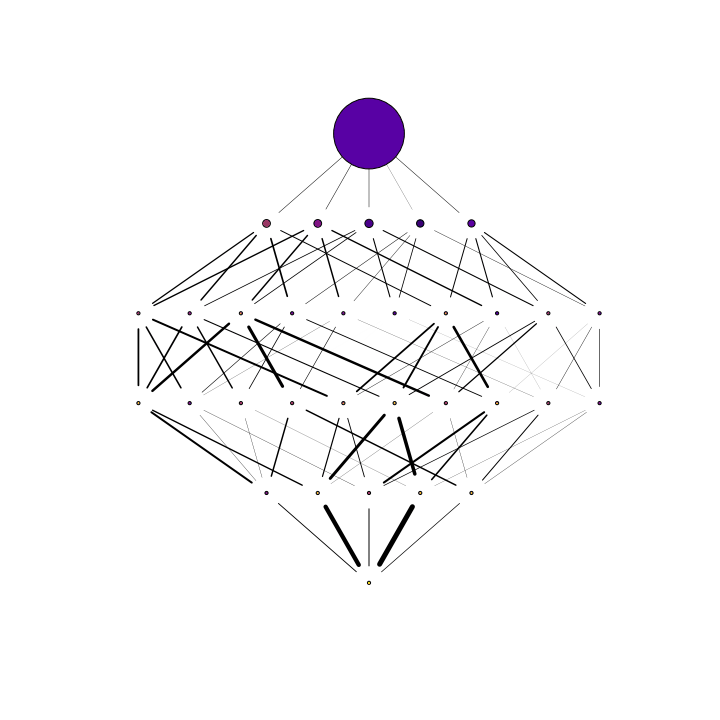

In [10]:
# animate flux over simulation


if os.path.exists('SLiM_demo/animate'):
    shutil.rmtree('SLiM_demo/animate')
os.mkdir('SLiM_demo/animate')    # make directory for animation frames
sim.animate_flux('SLiM_demo/animate/5_site')    # make gif
Image(open('SLiM_demo/animate/5_site.gif','rb').read())    # show gif